In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf

# Metadata Preprocessing:

In [2]:
Path.cwd()

WindowsPath('c:/Proyectos/George Brown Projects/2 Semester/Math Concepts DL 2/Project')

In [ ]:
images_foler_path = Path("../Data/lfw-deepfunneled/lfw-deepfunneled")
pairs_folder_path = Path("../Data/pairs_approach")
people_folder_path = Path("../Data/people_approach")

In [4]:
def rebuild_image_path(image_name, image_number):
    path = images_foler_path / image_name / f"{image_name}_{image_number:04d}.jpg"
    return path

In [7]:
example1 = rebuild_image_path("Aaron_Eckhart", 1)
example2 = rebuild_image_path("Arnold_Schwarzenegger", 17)
example2

WindowsPath('Data/lfw-deepfunneled/lfw-deepfunneled/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0017.jpg')

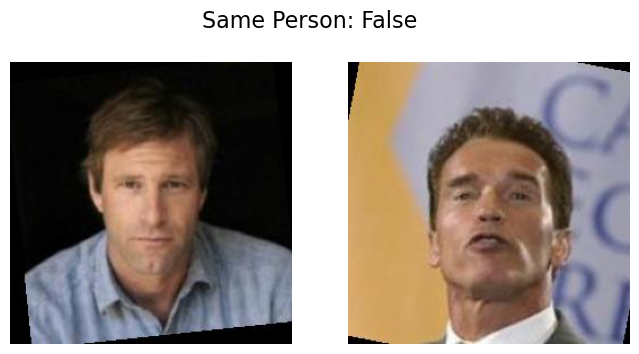

In [10]:
# Given the path, plot the image

def plot_pair(img_path1, img_path2, label=""):
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    
    if label != "":
        fig.suptitle(f"Same Person: {label == 1}", fontsize=16)
    
    axs[0].imshow(plt.imread(img_path1))
    axs[1].imshow(plt.imread(img_path2))
    for ax in axs: ax.axis('off')
    
plot_pair(example1, example2, 2)

# TODO: Use pillow to read the image and matplotlib to plot it.

### Train/Test:

Each data sample is a pair of images. The class is whether they are the same person or not. 1 for positiva pairs (same), 0 for negative pairs (different). The model will learn to predict if they are the same person or not.

🔹pairs.csv: 
- Is the original benchmark official file of LFW, which defines 10 folds for cross validation. This file will not be used, is just for reference.

🔹matchpairsDevTrain.csv, matchpairsDevTest.csv, mismatchpairsDevTrain.csv, mismatchpairsDevTest.csv
- Are the train/test files ready to use. Each train file has 1100 pairs while each test file has 500 pairs. 3300 samples in total.

**Why less than the original 6000?**
- There is 5758 people in total (people.csv file). Only 1184 have more than 1 image.
- The original 6000 samples were for cross validation.
- The 3300 pairs in the separate files are an organized subset ready to train and for fixed tests. Reproducivility.
- There is no need to use 10 folds (neither recommended if is not for cv).

In [14]:
allPairs = pd.read_csv(pairs_folder_path / "pairs.csv" ) 
# All the pre arranged pairs, every 600 rows is a new fold with 300 positive pairs and 300 negative.
# 10 folds in total.
allPairs

,name,imagenum1,imagenum2,Unnamed: 3
0,Abel_Pacheco,1,4,NaN
1,Akhmed_Zakayev,1,3,NaN
2,Akhmed_Zakayev,2,3,NaN
3,Amber_Tamblyn,1,2,NaN
4,Anders_Fogh_Rasmussen,1,3,NaN
...,...,...,...,...
5995,Scott_Wolf,2,Troy_Polamalu,1.0
5996,Sergei_Alexandrovitch_Ordzhonikidze,1,Yolanda_King,1.0
5997,Shane_Loux,1,Val_Ackerman,1.0
5998,Shawn_Marion,1,Shirley_Jones,1.0


In [9]:
allPairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        6000 non-null   object 
 1   imagenum1   6000 non-null   int64  
 2   imagenum2   6000 non-null   object 
 3   Unnamed: 3  3000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 187.6+ KB


In [10]:
matchPairsTrain = pd.read_csv(pairs_folder_path / "matchpairsDevTrain.csv" )
matchPairsTest = pd.read_csv(pairs_folder_path / "matchpairsDevTest.csv" )
missMatchPairsTrain = pd.read_csv(pairs_folder_path / "mismatchpairsDevTrain.csv" )
missMatchPairsTest = pd.read_csv(pairs_folder_path / "mismatchpairsDevTest.csv" )

print(f"Match Pairs Train shape: {matchPairsTrain.shape}")
print(f"Match Pairs Test shape: {matchPairsTest.shape}")
print(f"Miss Match Pairs Train shape: {missMatchPairsTrain.shape}")
print(f"Miss Match Pairs Test shape: {missMatchPairsTest.shape}")


Match Pairs Train shape: (1100, 3)
Match Pairs Test shape: (500, 3)
Miss Match Pairs Train shape: (1100, 4)
Miss Match Pairs Test shape: (500, 4)


### 🔹Building the TRAINING dataframe:

In [11]:
matchPairsTrain.head()

,name,imagenum1,imagenum2
0,Aaron_Peirsol,1,2
1,Aaron_Peirsol,3,4
2,Aaron_Sorkin,1,2
3,Abdel_Nasser_Assidi,1,2
4,Abdullah,1,3


In [12]:
trainFullMat_DF = pd.DataFrame()
trainFullMat_DF["image1_path"] = matchPairsTrain.apply(lambda x: rebuild_image_path(x['name'], x['imagenum1']), axis=1) # x is each row from matchPairsTrain.
trainFullMat_DF["image2_path"] = matchPairsTrain.apply(lambda x: rebuild_image_path(x['name'], x['imagenum2']), axis=1)
trainFullMat_DF["label"] = 1  # Matching pairs.
trainFullMat_DF.head()

,image1_path,image2_path,label
0,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_P...,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_P...,1
1,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_P...,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_P...,1
2,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_S...,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_S...,1
3,Data\lfw-deepfunneled\lfw-deepfunneled\Abdel_N...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdel_N...,1
4,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1


In [13]:
trainFullMat_DF.label.value_counts()

label
1    1100
Name: count, dtype: int64

In [14]:
missMatchPairsTrain

,name,imagenum1,name.1,imagenum2
0,AJ_Cook,1,Marsha_Thomason,1
1,Aaron_Sorkin,2,Frank_Solich,5
2,Abdel_Nasser_Assidi,2,Hilary_McKay,1
3,Abdoulaye_Wade,4,Linda_Dano,1
4,Abdul_Rahman,1,Magui_Serna,1
...,...,...,...,...
1095,Tom_Vilsack,1,Wayne_Ferreira,5
1096,Trisha_Meili,1,Vladimiro_Montesinos,3
1097,Ty_Votaw,1,Wayne_Allard,1
1098,Vytas_Danelius,1,Zaini_Abdullah,1


In [15]:
trainFullMis_DF = pd.DataFrame()
trainFullMis_DF["image1_path"] = missMatchPairsTrain.apply(lambda x: rebuild_image_path(x['name'], x['imagenum1']), axis=1)
trainFullMis_DF["image2_path"] = missMatchPairsTrain.apply(lambda x: rebuild_image_path(x['name.1'], x['imagenum2']), axis=1)
trainFullMis_DF["label"] = 0  # Non-matching pairs.
trainFullMis_DF.head()

,image1_path,image2_path,label
0,Data\lfw-deepfunneled\lfw-deepfunneled\AJ_Cook...,Data\lfw-deepfunneled\lfw-deepfunneled\Marsha_...,0
1,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_S...,Data\lfw-deepfunneled\lfw-deepfunneled\Frank_S...,0
2,Data\lfw-deepfunneled\lfw-deepfunneled\Abdel_N...,Data\lfw-deepfunneled\lfw-deepfunneled\Hilary_...,0
3,Data\lfw-deepfunneled\lfw-deepfunneled\Abdoula...,Data\lfw-deepfunneled\lfw-deepfunneled\Linda_D...,0
4,Data\lfw-deepfunneled\lfw-deepfunneled\Abdul_R...,Data\lfw-deepfunneled\lfw-deepfunneled\Magui_S...,0


In [16]:
trainFullMis_DF.label.value_counts()

label
0    1100
Name: count, dtype: int64

Concatenate the matching and non-matching **TRAINING** dataframes:

- (Before concatenating, extract some data for the validation set)

In [17]:
# 10% of the matching pairs for validation.
validMat_DF = trainFullMat_DF.sample(frac=0.1, replace=False, random_state=42)
# remaining 90% for training.
trainMat_DF = trainFullMat_DF.drop(validMat_DF.index)

# 10% of the non-matching pairs for validation.
validMis_DF = trainFullMis_DF.sample(frac=0.1, replace=False, random_state=42)
# remaining 90% for training.
trainMis_DF = trainFullMis_DF.drop(validMis_DF.index)

print(f"Training Matching Pairs after split: {trainMat_DF.shape}")
print(f"Training Non-Matching Pairs after split: {trainMis_DF.shape}")
print(f"Validation Matching Pairs: {validMat_DF.shape}")
print(f"Validation Non-Matching Pairs: {validMis_DF.shape}")

Training Matching Pairs after split: (990, 3)
Training Non-Matching Pairs after split: (990, 3)
Validation Matching Pairs: (110, 3)
Validation Non-Matching Pairs: (110, 3)


In [18]:
trainDF = pd.concat([trainMat_DF, trainMis_DF], ignore_index=True)
validDF = pd.concat([validMat_DF, validMis_DF], ignore_index=True)

print("Train set balance:\n", trainDF.label.value_counts())
print("Valid set balance:\n", validDF.label.value_counts())


Train set balance:
 label
1    990
0    990
Name: count, dtype: int64
Valid set balance:
 label
1    110
0    110
Name: count, dtype: int64


In [19]:
# Show some samples from the middle of the training dataframe.
mid = len(trainDF)//2
trainDF.iloc[mid-3:mid+3]

,image1_path,image2_path,label
987,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,1
988,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,1
989,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,Data\lfw-deepfunneled\lfw-deepfunneled\Zhu_Ron...,1
990,Data\lfw-deepfunneled\lfw-deepfunneled\AJ_Cook...,Data\lfw-deepfunneled\lfw-deepfunneled\Marsha_...,0
991,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_S...,Data\lfw-deepfunneled\lfw-deepfunneled\Frank_S...,0
992,Data\lfw-deepfunneled\lfw-deepfunneled\Abdel_N...,Data\lfw-deepfunneled\lfw-deepfunneled\Hilary_...,0


In [20]:
# Show some samples from the middle of the validation dataframe.
mid = len(validDF)//2
validDF.iloc[mid-3:mid+3]

,image1_path,image2_path,label
107,Data\lfw-deepfunneled\lfw-deepfunneled\Mel_Bro...,Data\lfw-deepfunneled\lfw-deepfunneled\Mel_Bro...,1
108,Data\lfw-deepfunneled\lfw-deepfunneled\Marilyn...,Data\lfw-deepfunneled\lfw-deepfunneled\Marilyn...,1
109,Data\lfw-deepfunneled\lfw-deepfunneled\Munir_A...,Data\lfw-deepfunneled\lfw-deepfunneled\Munir_A...,1
110,Data\lfw-deepfunneled\lfw-deepfunneled\Christi...,Data\lfw-deepfunneled\lfw-deepfunneled\Pat_Roc...,0
111,Data\lfw-deepfunneled\lfw-deepfunneled\Ian_Wil...,Data\lfw-deepfunneled\lfw-deepfunneled\Randall...,0
112,Data\lfw-deepfunneled\lfw-deepfunneled\David_B...,Data\lfw-deepfunneled\lfw-deepfunneled\Job_Coh...,0


### 🔹 Building the TEST dataframe:

In [21]:
matchPairsTest.head()

,name,imagenum1,imagenum2
0,Abdullah_Gul,13,14
1,Abdullah_Gul,13,16
2,Abdullatif_Sener,1,2
3,Adel_Al-Jubeir,1,3
4,Al_Pacino,1,2


In [22]:
testMat_DF = pd.DataFrame()
testMat_DF["image1_path"] = matchPairsTest.apply(lambda x: rebuild_image_path(x['name'], x['imagenum1']), axis=1)
testMat_DF["image2_path"] = matchPairsTest.apply(lambda x: rebuild_image_path(x['name'], x['imagenum2']), axis=1)
testMat_DF["label"] = 1  # Matching pairs.
testMat_DF.head()

,image1_path,image2_path,label
0,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1
1,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1
2,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1
3,Data\lfw-deepfunneled\lfw-deepfunneled\Adel_Al...,Data\lfw-deepfunneled\lfw-deepfunneled\Adel_Al...,1
4,Data\lfw-deepfunneled\lfw-deepfunneled\Al_Paci...,Data\lfw-deepfunneled\lfw-deepfunneled\Al_Paci...,1


In [23]:
testMat_DF.label.value_counts()

label
1    500
Name: count, dtype: int64

In [24]:
missMatchPairsTest.head()

,name,imagenum1,name.1,imagenum2
0,AJ_Lamas,1,Zach_Safrin,1
1,Aaron_Guiel,1,Reese_Witherspoon,3
2,Aaron_Tippin,1,Jose_Luis_Rodriguez_Zapatero,1
3,Abdul_Majeed_Shobokshi,1,Charles_Cope,1
4,Abdullah_Gul,16,Steve_Cox,1


In [25]:
testMis_DF = pd.DataFrame()
testMis_DF["image1_path"] = missMatchPairsTest.apply(lambda x: rebuild_image_path(x['name'], x['imagenum1']), axis=1)
testMis_DF["image2_path"] = missMatchPairsTest.apply(lambda x: rebuild_image_path(x['name.1'], x['imagenum2']), axis=1)  
testMis_DF["label"] = 0  # Non-matching pairs.
testMis_DF.head()

,image1_path,image2_path,label
0,Data\lfw-deepfunneled\lfw-deepfunneled\AJ_Lama...,Data\lfw-deepfunneled\lfw-deepfunneled\Zach_Sa...,0
1,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_G...,Data\lfw-deepfunneled\lfw-deepfunneled\Reese_W...,0
2,Data\lfw-deepfunneled\lfw-deepfunneled\Aaron_T...,Data\lfw-deepfunneled\lfw-deepfunneled\Jose_Lu...,0
3,Data\lfw-deepfunneled\lfw-deepfunneled\Abdul_M...,Data\lfw-deepfunneled\lfw-deepfunneled\Charles...,0
4,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Steve_C...,0


In [26]:
testMis_DF.label.value_counts()

label
0    500
Name: count, dtype: int64

Concatenate the matching and non-matching **TEST** dataframes.

In [27]:
testDF = pd.concat([testMis_DF, testMat_DF], ignore_index=True)

mid = len(testDF)//2
# Show some samples from the middle of the test dataframe.
testDF.iloc[mid-3:mid+3]

,image1_path,image2_path,label
497,Data\lfw-deepfunneled\lfw-deepfunneled\Tamara_...,Data\lfw-deepfunneled\lfw-deepfunneled\Zach_Pa...,0
498,Data\lfw-deepfunneled\lfw-deepfunneled\Tatiana...,Data\lfw-deepfunneled\lfw-deepfunneled\Thomas_...,0
499,Data\lfw-deepfunneled\lfw-deepfunneled\Todd_Pe...,Data\lfw-deepfunneled\lfw-deepfunneled\Vicente...,0
500,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1
501,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1
502,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,Data\lfw-deepfunneled\lfw-deepfunneled\Abdulla...,1


In [28]:
x_train = trainDF[["image1_path", "image2_path"]]
y_train = trainDF["label"]
x_valid = validDF[["image1_path", "image2_path"]]
y_valid = validDF["label"]
x_test = testDF[["image1_path", "image2_path"]]
y_test = testDF["label"]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (1980, 2), y_train shape: (1980,)
x_valid shape: (220, 2), y_valid shape: (220,)
x_test shape: (1000, 2), y_test shape: (1000,)


In [29]:
# tensorflow doesn't know how to manage Path objects, so we need to convert them to strings.
x_train = x_train.astype(str)
x_valid = x_valid.astype(str)

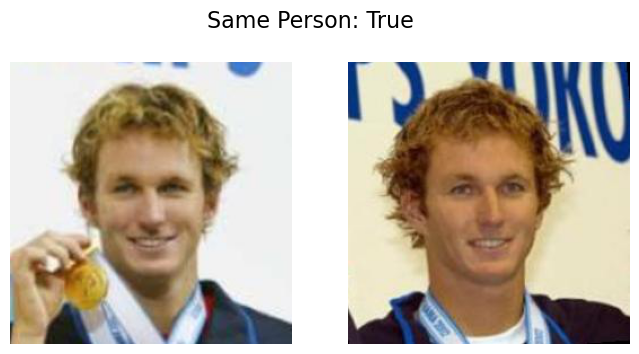

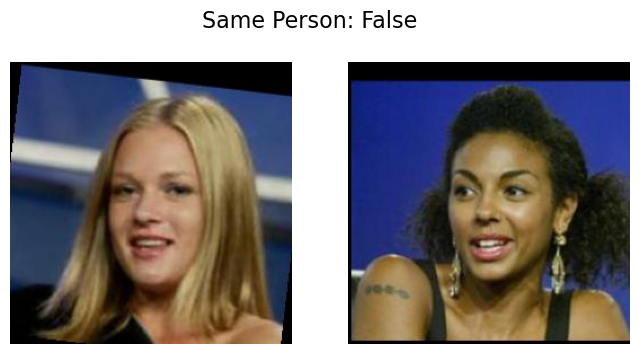

In [30]:
# plot the first postivie and negative training pairs:
half = len(y_train)//2

plot_pair(*x_train.iloc[0], y_train.iloc[0])
plot_pair(*x_train.iloc[half], y_train.iloc[half])

# Model Implementation

In [31]:
IMG_SIZE = (160, 160)
EMB_DIM = 128
BATCH_SIZE = 32

In [32]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2794363..0.920489].


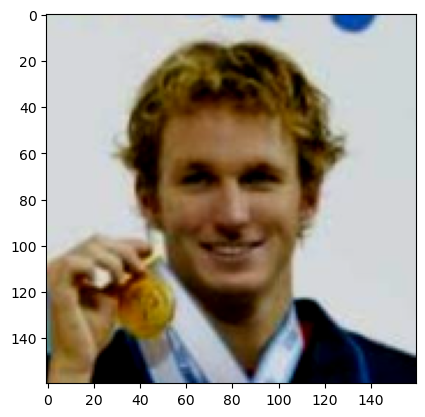

In [34]:
img_prueba = load_and_preprocess_image(x_train.iloc[0,0])
plt.imshow(img_prueba)

img_prueba_aug = augment(img_prueba)
plt.imshow(img_prueba_aug)